This notebook shows an example of how to conduct a point-source analysis.
The core of the analysis is a binned poisson likelihood evaluation using Asimov data.
The histograms of the analysis are the effective area, the energy resolution, the angular resolution and the atmospheric background model.
Core functions of the PLEnuM software are used in this example.

In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
# # need to run once in the beginning to prepare all ingredients for the analysis
# # this might take several minutes

# # run these only if you haven't done so before
# # load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# # calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# # run these every time there are updates to resolution, binning, or mephistograms
# # load and prepare the energy and angular resolutions
# %run ../../core/resolution.py

# # gather all ingredients and save them as unified 'mephistogram' data structure
# %run ../../core/prepare_histograms.py

# Imports

In [ ]:
import pickle
from collections import namedtuple
from copy import copy
from os.path import join

import numpy as np
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import *
from tools import array_source_interp
from likelihood import poisson_llh

from fluxes import power_law
import pandas as pd
from tools import scaling_estimation, get_scaler
from likelihood import ps_llh_single
import settings as st
from mephisto import like

cmap = "mako"


/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Point-source binning!


# Default binning

In [4]:
print(len(logE_bins), np.min(logE_bins), np.max(logE_bins))
print(len(logE_reco_bins), np.min(logE_reco_bins), np.max(logE_reco_bins))
print(len(sindec_bins), np.min(sindec_bins), np.max(sindec_bins))


141 2.0 8.999999999999975
140 2.0 8.949999999999974
502 -1.0 1.0


# Source parameters

In [5]:
# livetime of 10yrs in seconds and days
print(LIVETIME, LIVETIME / 24 / 3600)
# Normalization energy of power law (E/E_NORM)^GAMMA_ASTRO
print(E_NORM)  # in GeV
# Source flux spectral index
# see https://arxiv.org/abs/2111.10299?context=astro-ph
print(GAMMA_ASTRO)  # spectral index
print(PHI_ASTRO)  # neutrinos * (E/E_NORM)^GAMMA_ASTRO / GeV / cm^2 / s / sr
print(BASEPATH)
print(LOCALPATH)


308975040.0 3576.1
100000.0
2.37
1.44e-18
/home/hpc/capn/capn102h/repos/Plenum
/home/hpc/capn/capn102h/repos/Plenum/local


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [24]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)


# Background

In [25]:
# MCEQ: atmospheric flux on muon neutrinos (see also 'background_flux.ipynb')
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)


# Energy smearing

In [ ]:
# energy smearing matrix
with open(join(LOCALPATH, "energy_smearing_GP_up.pckl"), "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [9]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

# Source flux definition
$N_{\nu} = T_{\rm live} \cdot \int_{\Delta \Omega} d \Omega \, d E \, \int_{E_{\min}}^{E_{\max}} dE \, A_{\rm eff} \left( E, \sin(\delta)\right) \cdot \frac{d \Phi}{d E} $

Approximate the integral with a finite-binning approach:

aeff_factor =
$ 2\pi \cdot \Delta \sin (\delta) \, \Delta E \cdot A_{\rm eff} \left( E, \sin(\delta)\right) $ 

($2\pi = \int_0^{2\pi} d\phi$; $d \Omega = d \phi \cdot d \sin(\delta)$)

In [10]:
# we base the flux models on named-tuples
from fluxes import PL_flux
ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")


In [11]:
# ngc1068 source config
ngc_src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
    dec=ngc1068.dec.rad,
)
# corresponding bg config
ngc_bg_config = copy(ngc_src_config)
ngc_bg_config["dpsi_max"] = delta_psi_max
ngc_bg_config["grid_2d"] = bckg_psi2_grid



## Check event numbers

In [12]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s)) 


ngc 1068: 98.2082534964597


# DEMO: differential sensitivity

Fit one bin

In [13]:
ident = "IceCube"

aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal_full = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

_slicer = 10  # ten parts of the energy binning per differential-bin
_num = 4 # fit the third bin
_idx_select = np.arange(_num * _slicer, (_num + 1) * _slicer)
aeff_factor_signal = like(aeff_factor_signal_full)
aeff_factor_signal.histo[:, _idx_select] = aeff_factor_signal_full.histo[:, _idx_select]

# asimov data
k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    bckg_vals=array_source_interp(ngc_src_config["dec"], bckg_histo["IceCube"], sindec_mids, axis=1),
    energy_resolution=baseline_eres,
)
# power law
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,  # powerlaw
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))


dct = dict(
    aeff_factor_b=k_b,
    fixed_BG=True, bckg_flux=None, # pre-computed BG
    aeff_factor_s=aeff_factor_signal,
    k_i=k_i,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
    shape="powerlaw"
)

# fix signal normalization to 0
local_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)
global_llh = lambda x: ps_llh_single(x, **dct)

out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# this fit is not really needed, but good for crosschecking the code
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, ngc_flux.gamma),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)

Asimov data sum:
Background: 1488.281037312281
Signal: 5.862812845437682
Atmo-only normalization: [1.00393935]
Signal fit parameters: [1.  1.  3.2]
TS check: -306526.07156348816 (fit:  -306526.07156348816 )
-2 Delta LLH: 0.8969526805449277
P-VALUE: 0.6386004204728923 SIGNIFICANCE: -0.3547202764953024


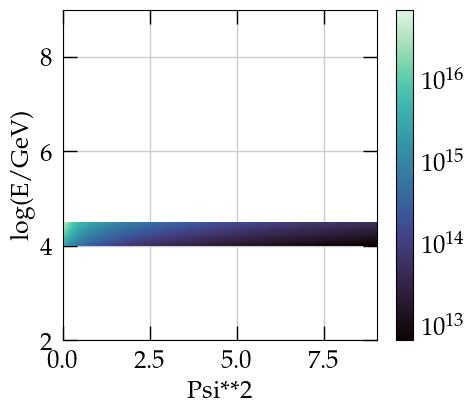

In [14]:
aeff_factor_signal.plot(norm=LogNorm())

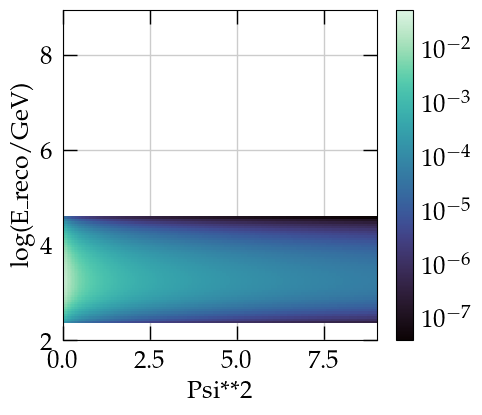

In [15]:
k_s.plot(norm=LogNorm())

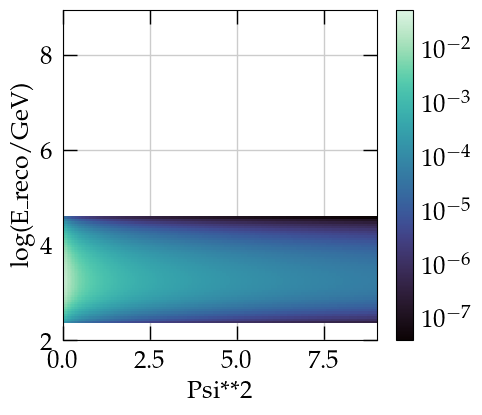

In [16]:
k_s.plot(norm=LogNorm())

# Find 3 sigma evidence flux per energy bin

This is technically no limit/sensitivity construction, as it find the flux where 3 sigma background TS <= median signal TS. 
It's rather a differential "evidence potential" based on the 3 sigma-level significance per energy bin.
This is simply easier to calculate, as the probability of the background TS is known (chi**2), but the signal TS can have a more complicated probability distr.

Usually, sensitivity is constructed via 90% signal TS >= median background TS. This could be done via pseudo experiments or describing the signal TS distribution.

In [97]:
ident = "IceCube"
thresholds = [sigma3]
tmp = []  # save output here

# this can be adjusted to larger/smaller energy bins:
_slicer = 10  # ten parts of the energy binning per differential-bin, yields 14 slices

_E0 = 1e3  # same energy pivot point/norm for all fluxes
_fluxnorm = 1e-12  # same norm for all fluxes
# (these values work well together when estimating the scaling factors)


aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal_full = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

# build full background mock data
k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    bckg_vals=array_source_interp(
        ngc_src_config["dec"], bckg_histo["IceCube"], sindec_mids, axis=1
    ),
    energy_resolution=baseline_eres,
)

for gamma in [2.0, 2.5, 3.0]:
    # build flux model for specific spectral index
    _flux = PL_flux(_fluxnorm, gamma, _E0, "powerlaw")

    # loop over the energy slices
    for _num in np.arange(0, aeff_factor_signal_full.shape[-1] // _slicer):
        # select the right bin indices for this specific slice
        _idx_select = np.arange(_num * _slicer, (_num + 1) * _slicer)

        # sub-selection of signal based on sub-selected indices
        aeff_factor_signal = like(aeff_factor_signal_full)
        aeff_factor_signal.histo[:, _idx_select] = aeff_factor_signal_full.histo[
            :, _idx_select
        ]

        # build the power law model - but only a slice of it
        k_s = astro_flux(
            aeff_factor=aeff_factor_signal,
            emids=emids,
            energy_resolution=baseline_eres,
            phi_scaling=1,
            flux_shape=_flux,  # powerlaw
        )
        # full mock data: full background + slice of signal
        k_i = k_s + k_b


        # calculate an estimate for the flux scaling
        scaler = 0.5 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        current_thresholds = copy(thresholds)
        count = 0

        # calculate the significance with various flux scalings to obtain
        # the desired significance threshold by interpolation
        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = k_s * scaler
            current_k_i = current_k_s + k_b

            dct = dict(
                aeff_factor_b=k_b,
                fixed_BG=True,
                bckg_flux=None,  # pre-computed BG - it's always the same
                aeff_factor_s=aeff_factor_signal,
                k_i=current_k_i,
                e_0=_flux.E0,
                phi_0=_flux.norm,
                energy_resolution=baseline_eres,
                shape="powerlaw",
            )

            # fix signal normalization to 0 for background fit
            local_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)
            # full fit for signal + background
            global_llh = lambda x: ps_llh_single(x, **dct)

            # bg-only fit
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1,),
                approx_grad=True,
            )

            # signal + bg fit
            # this fit is not really needed, but good for crosschecking the code
            # it should yield the input signal+background parameters.
            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, _flux.gamma),
                approx_grad=True,
            )
            pval = chi2.sf(out_bckg[1] - out_comp[1], 2)

            # populate the results dictionary, so we can interpolate the flux values later
            tmp_dct = {
                "ident": ident,
                # "dec": dec,
                "ebin_num": _num,
                "gamma": _flux.gamma,
                "E0": _flux.E0,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(k_b)),
                "n_b": np.sum(k_b),
                "n_sig": np.sum(current_k_s),
                "pval": pval,
                "log10(p)": -np.log10(pval),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.cur_thresh == current_thresholds[0])
                # & (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.ebin_num == _num)
                & (tmp_df.gamma == gamma)
            )
            # calculate the next best scaling factor
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )
            # rinse and repeat until scaling_estimation says so
            if scaler == -1:
                break

df = pd.DataFrame(tmp)

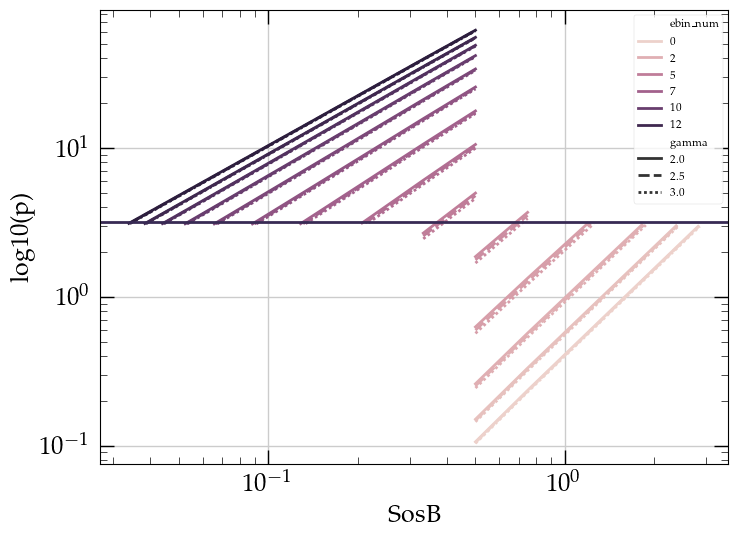

In [98]:
# check if the sampling and interpolation worked
ax = sns.lineplot(
    data=df,
    x="SosB",
    y="log10(p)",
    hue="ebin_num",
    style="gamma",
)
ax.axhline(-np.log10(sigma3))
ax.loglog()
ax.legend(fontsize="xx-small")

In [99]:
flux = pd.DataFrame(
    df.groupby(["ident", "ebin_num", "gamma", "E0"]).apply(
        lambda x: get_scaler(x, sigma3) # find 3sigma threshold from flux sampling points
    )
    * _fluxnorm,  # same norm for all fluxes
    columns=["disc3"],
).reset_index()
flux["emin"] = st.logE_bins[flux.ebin_num * _slicer]
flux["emax"] = st.logE_bins[(flux.ebin_num + 1) * _slicer]

Text(0.5, 0, 'Lower bound of energy bin, $\\log_{10}(E_{\\rm min} \\rm / GeV )$')

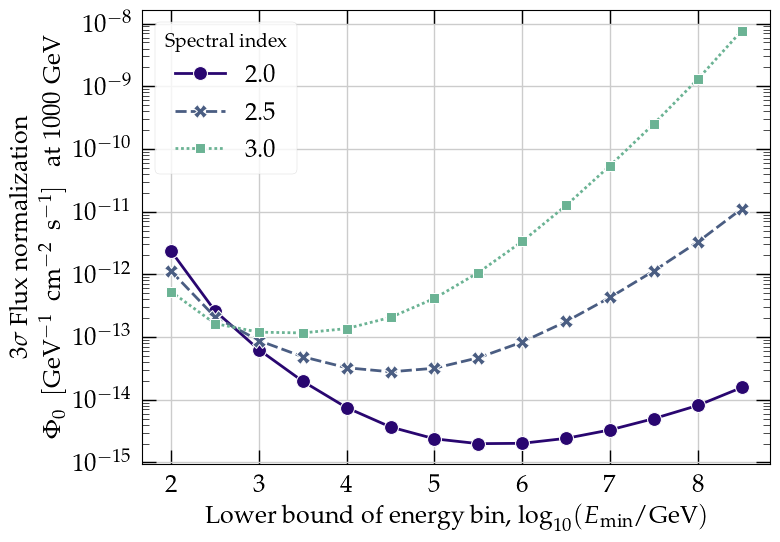

In [128]:
ax = sns.lineplot(
    flux,
    x="emin",
    y="disc3",
    hue="gamma",
    style="gamma",
    palette=sns.color_palette("blend:#290670,#6bb394", n_colors=3),
    markers=True,
    ms=10,
)
ax.set_yscale("log")
ax.get_legend().set_title("Spectral index")
ax.set_ylabel(
    r"$3 \sigma$ Flux normalization"
    + " \n "
    + rf"$ \Phi_0 \rm~~[GeV^{{{-1}}} ~~ cm^{{{-2}}} ~~ s^{{{-1}}}]$ ~~at {_E0:1.0f} GeV"
)
ax.set_xlabel(r"Lower bound of energy bin, $\log_{10}(E_{\rm min} \rm / GeV )$")

(5e-10, 2e-05)

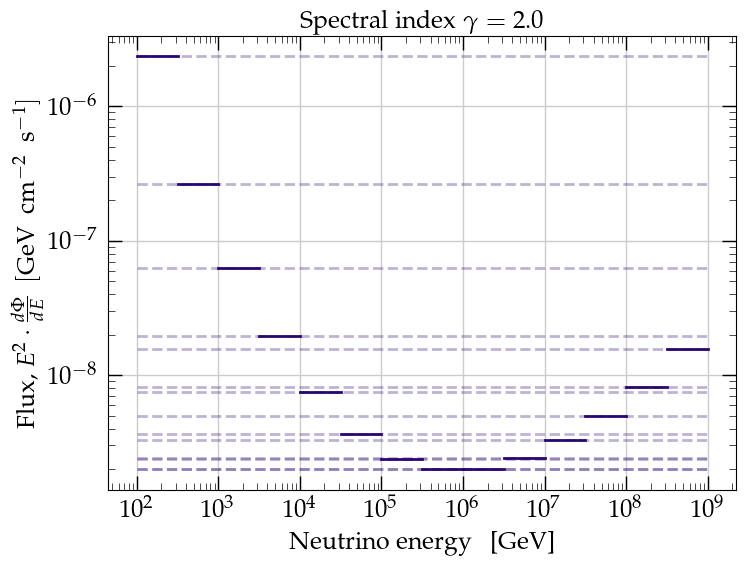

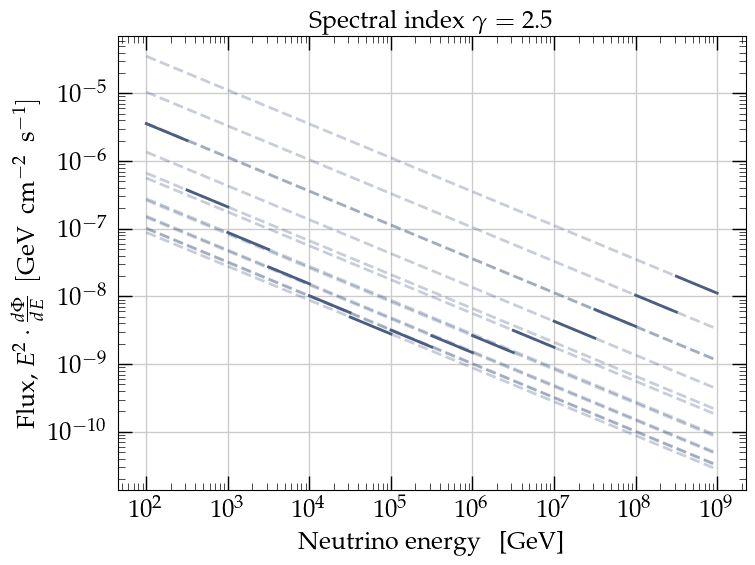

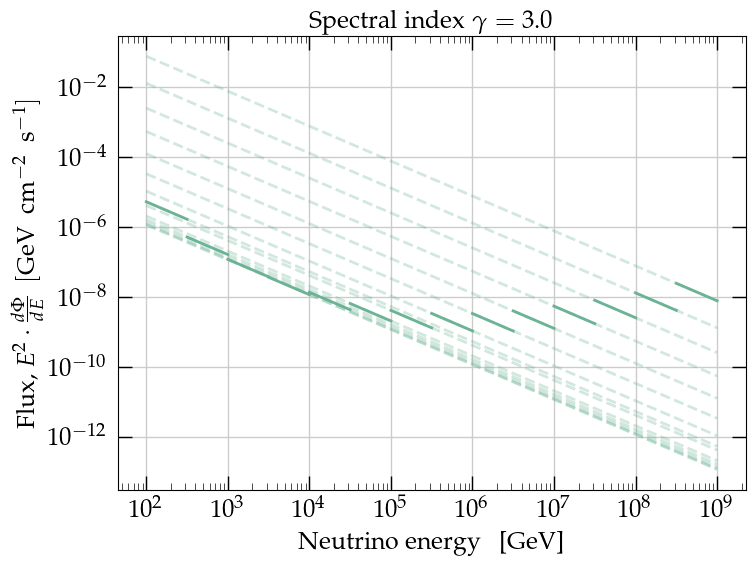

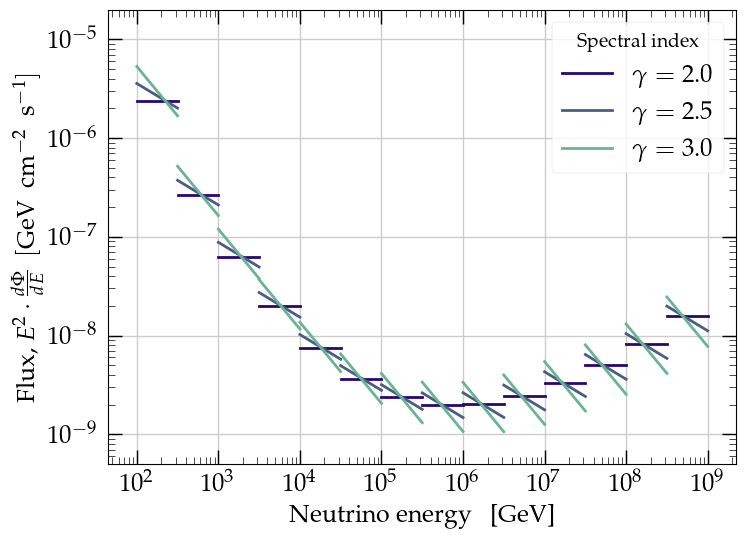

In [129]:
_c = sns.color_palette("blend:#290670,#6bb394", n_colors=3)
_colors = {2.0: _c[0], 2.5: _c[1], 3.0: _c[2]}

## flux * E**2
plt.figure(1)
plt.loglog()
plt.xlabel(r"Neutrino energy ~~[GeV]")
plt.ylabel(r"Flux, $E^2 \cdot \frac{d\Phi}{dE} \rm ~~[GeV ~~ cm^{-2} ~~ s^{-1}]$")

## bare flux
# plt.figure(2)
# plt.loglog()
# plt.axvline(_E0, lw=1, color="gray")
# plt.xlabel(r"Neutrino energy ~~[GeV]")
# plt.ylabel(r"Flux, $\frac{d\Phi}{dE} \rm ~~[GeV^{-1} ~~ cm^{-2} ~~ s^{-1}]$")

for _g, _df in flux.groupby("gamma"):
    plt.figure(1)
    # for legend
    plt.plot(
        [0, 0],
        [1, 1],
        color=_colors[_g],
        label=rf"$\gamma={_g}$",
    )

    f, ax = plt.subplots()
    ax.set_title(rf"Spectral index $\gamma={_g}$")
    ax.set_xlabel(r"Neutrino energy ~~[GeV]")
    ax.set_ylabel(
        r"Flux, $E^2 \cdot \frac{d\Phi}{dE} \rm ~~[GeV ~~ cm^{-2} ~~ s^{-1}]$"
    )
    ax.loglog()
    for _, series in _df.iterrows():
        _e = 10 ** np.linspace(series.emin, series.emax)

        plt.figure(1)
        plt.plot(
            _e,
            power_law(_e, _E0, _g, series.disc3) * _e**2,
            color=_colors[_g],
            # label=rf"$\gamma={_g}$",
        )
        # plt.figure(2)
        # plt.plot(
        #     _e,
        #     power_law(_e, _E0, _g, series.disc3),
        #     color=_colors[_g],
        # )
        # plt.plot(
        #     st.ebins,
        #     power_law(st.ebins, _E0, _g, series.disc3),
        #     color=_colors[_g],
        #     ls="--",
        #     alpha=0.3,
        # )

        # plot individual PL slices with respective flux normalizations
        ax.plot(
            _e,
            power_law(_e, _E0, _g, series.disc3) * _e**2,
            color=_colors[_g],
        )
        ax.plot(
            st.ebins,
            power_law(st.ebins, _E0, _g, series.disc3) * st.ebins**2,
            color=_colors[_g],
            ls="--",
            alpha=0.3,
        )
plt.figure(1)
plt.legend(title="Spectral index")
plt.ylim(5E-10, 2E-5)

... nice to see that the differential performance is largely independent of the injected spectral index